In [57]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [58]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


### Importing MIDI

music21 can be used to open, manipulate, play and save MIDI files.

In [59]:
from pathlib import Path
import music21 as m21

musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

final_fantasy_midi_path = Path('data/midi/Mana_GB_Final Fantasy Adventure_Battle 2.mid')
final_fantasy_midi = m21.midi.MidiFile()
final_fantasy_midi.open(final_fantasy_midi_path)
final_fantasy_midi.read()
final_fantasy_midi.close()

final_fantasy_midi

<music21.midi.MidiFile 2 tracks>

If we convert the MIDI file into a music21 stream we can play it back OK

In [60]:
final_fantasy_m21stream = m21.midi.translate.midiFileToStream(final_fantasy_midi)
final_fantasy_m21stream.show('midi')

We can get the bytes of a single track

In [61]:
final_fantasy_midi_trk_0 = final_fantasy_midi.tracks[0]
final_fantasy_midi_trk_0.getBytes()

b'MTrk\x00\x00\x00\xd5\x00\xffT\x05`\x00\x00\x00\x00\x00\xffX\x04\x04\x02\x18\x08\x00\xffY\x02\x02\x00\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\xa0\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfe\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfd\x7f\xff/\x00'

However, if we try playing a single track stream it goes to shit because the timing info is in the parent track stream. I was a bit surprised as the merged track has all the tempo track info but ah well.

In [62]:
final_fantasy_m21stream_trk_0 = m21.midi.translate.midiTrackToStream(final_fantasy_midi_trk_0)
final_fantasy_m21stream_trk_0.show('midi')

It's looking like encoding the raw MIDI might be tricky, although something in my gut tells me it is the right way, or at least there is some insight to be had.

I think the best way forward is to pull in the basics from musicautobot and try to understand them. No point in running before we walk and all that.

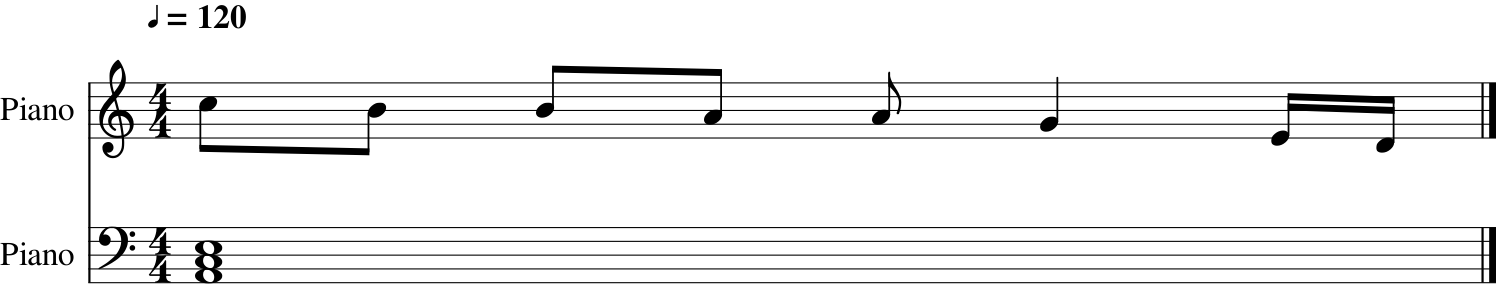

In [63]:
single_bar_path = Path('data/midi/single_bar_example.mid')

single_bar_midi_file = m21.midi.MidiFile()
single_bar_midi_file.open(single_bar_path)
single_bar_midi_file.read()
single_bar_midi_file.close()

single_bar_stream = m21.midi.translate.midiFileToStream(single_bar_midi_file)
single_bar_stream.show()

The offset in the left column is in 'quarter bars'

In [64]:
single_bar_stream.show('text')

{0.0} <music21.stream.Part 0x7f93927f3250>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Note B>
        {1.5} <music21.note.Note A>
        {2.0} <music21.note.Note A>
        {2.5} <music21.note.Note G>
        {3.5} <music21.note.Note E>
        {3.75} <music21.note.Note D>
        {4.0} <music21.bar.Barline type=final>
{0.0} <music21.stream.Part 0x7f93927f3b80>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A2 C3 E3>
        {4.0} <music21.bar.Barline type=final>


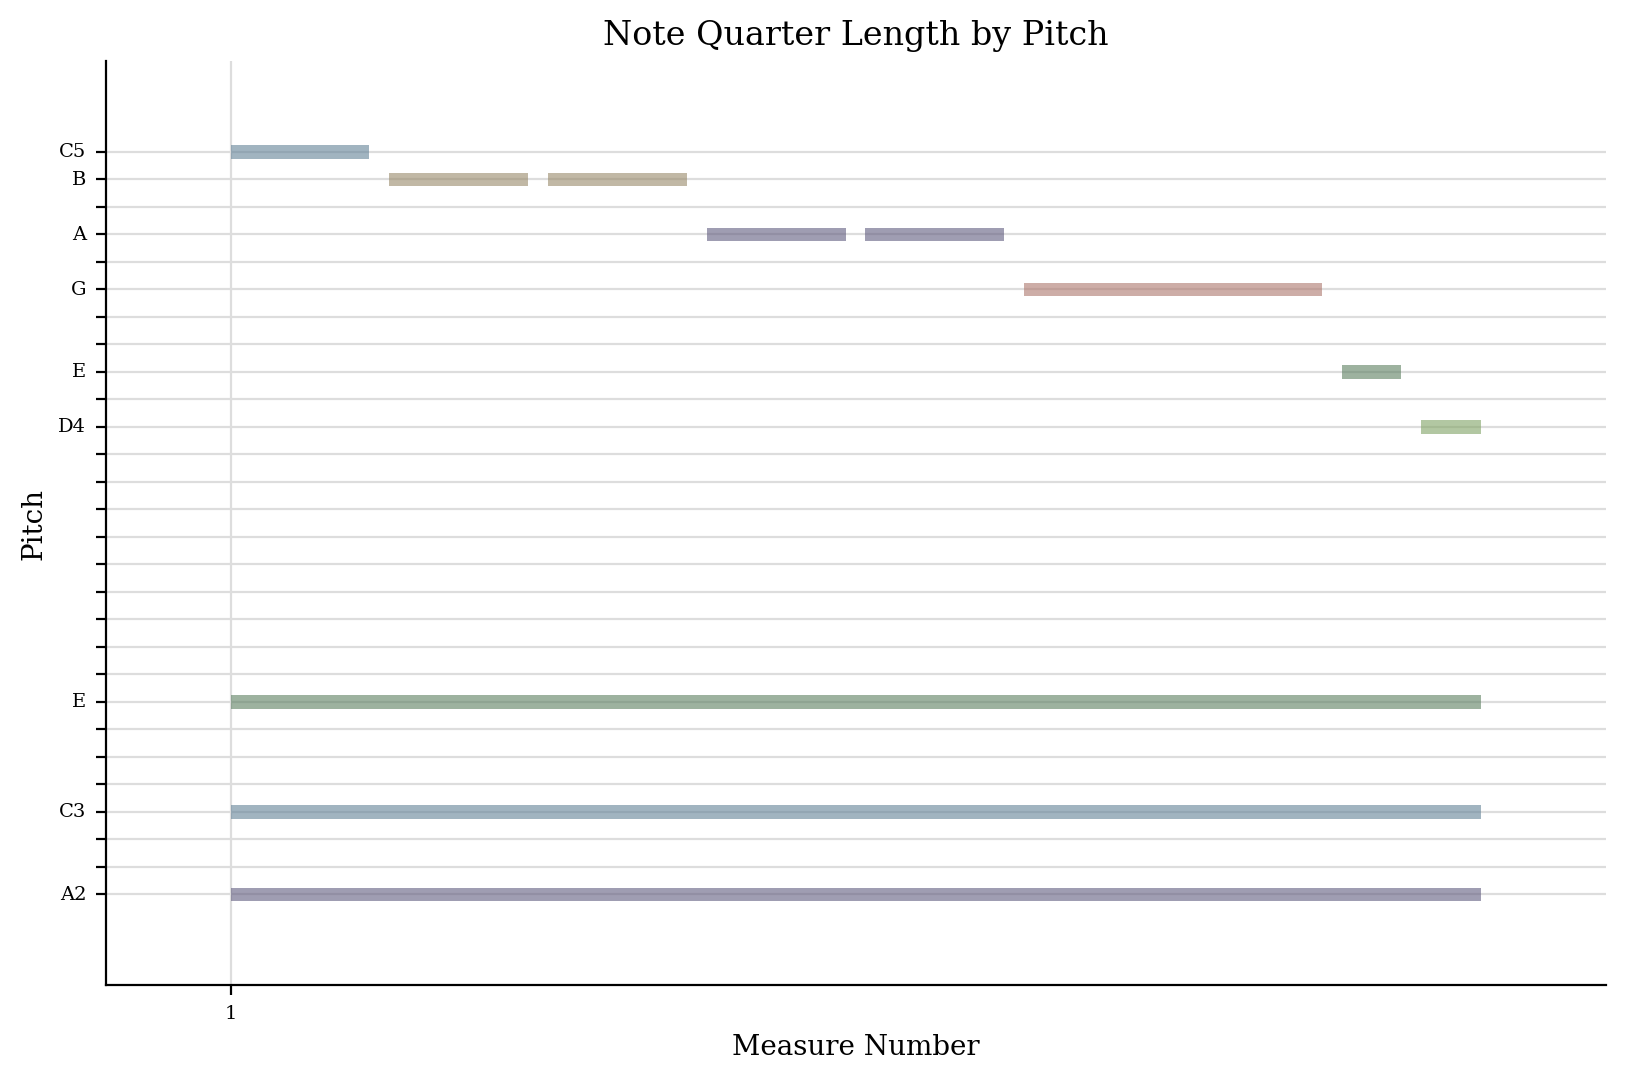

In [65]:
single_bar_stream.plot()

### One Hot Encoding

Code to convert a music21 stream into a psuedo one-hot encoded score adapted from musicautobot's `numpy_encode` module.

In [66]:
from itertools import chain

HELD_NOTE_VAL = -2 # Used to indicate held note in sparse score sparse array
BEATS_PER_BAR = 4 # beats per bar
DIVISIONS_PER_QUARTER = 4 # i.e. 4 beats per bar and 4 divisions per beat gives 16 divisions per bar
MIDI_NOTE_COUNT = 128
MAX_NOTE_DUR = (8*BEATS_PER_BAR*DIVISIONS_PER_QUARTER)

def stream_to_sparse_enc(stream_score, note_size=MIDI_NOTE_COUNT, sample_freq=DIVISIONS_PER_QUARTER, max_note_dur=MAX_NOTE_DUR):
    "Converts music21.Stream to 1-hot numpy array"
    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (Author) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq)+1

    # Array to hold the one hot encoding of the score
    # sparse_score = np.zeros((max_timestep, len(m21stream_score.parts), note_size))
    sparse_score = torch.zeros((max_timestep, len(stream_score.parts), note_size), dtype=torch.int32, device=device)

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx,part in enumerate(stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by offset (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for n in notes_sorted:
            
            if n is None: continue

            pitch,offset,duration = n # Unpack the note tuple
            clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration

            # Set the first active position for the note in the 'one hot encoded' score to duration value (also used when decoding)
            sparse_score[offset, idx, pitch] = clamped_duration

            # Continue holding the note for the duration, set to a contant value of -2
            sparse_score[offset+1:offset+clamped_duration, idx, pitch] = HELD_NOTE_VAL # Continue holding note
    
    return sparse_score

In [67]:
sparse_score = stream_to_sparse_enc(single_bar_stream); 
sparse_score.shape

torch.Size([17, 2, 128])

`nonzero()` gives us the row and column indices of the non zero elements.

At timestep 1 (instrument * pitch), we can see that instrument (row) 0 has pitch (col) 72 active.

Instrument 1 has pitches 45, 48 and 52 active (A2 C3 E3).

In [68]:
timestep_1 = sparse_score[1].nonzero(); 
timestep_1

tensor([[ 0, 72],
        [ 1, 45],
        [ 1, 48],
        [ 1, 52]], device='cuda:0')

The value stored at the position indexed by `timestep*instrument*pitch` is the **length in beats** of that note.

For instance at timestep 0, on intrument 1, pitches 45, 48 and 52 begin to play for 16 beats:

In [69]:
sparse_score[0, 1]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0, 16,  0,  0,  0, 16,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0', dtype=torch.int32)

As these are held over the next 15 timesteps, the positions are padded with a constant `-2` (the index of the text token `VALTCONT`)

In [70]:
sparse_score[1, 1]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0, -2,  0,  0,  0, -2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0', dtype=torch.int32)

In [71]:
sparse_score[2, 1]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0, -2,  0,  0,  0, -2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0', dtype=torch.int32)

> This structure shows how `non-zero` gives us the active columns. The array is psuedo-one-hot, even though numbers aren't clamped to 0 or 1.

### Dense Encoding

Sparse one-hot encoding is too inefficient, so we want to just store what notes play and for how long.

Another function adapted from MusicAutobot:

In [72]:
from functools import reduce

SEPARATOR_IDX = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)

# Pass in the 'one-hot' encoded numpy score
def sparse_to_note_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_note_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0: 
                encoded_timesteps.append([SEPARATOR_IDX, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([SEPARATOR_IDX, final_wait_count]) # add trailing rests

    return torch.tensor(encoded_timesteps, dtype=torch.int32, device=device).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_note_position_enc(timestep, note_range=PIANO_RANGE):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument,note = active_note_idx
        duration = timestep[instrument, note]
        if duration != HELD_NOTE_VAL and note >= note_min and note < note_max: 
            note_data.append([note, duration, instrument])
        return note_data
    
    encoded_notes = reduce(encode_note_data, timestep.nonzero(), [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)

    # Dropping instrument information for simplicity.
    # MusicAutobot allows different encoding schemes which include instrument number and split pitch into class / octave.
    return [n[:2] for n in sorted_notes] 

This considerably reduces the size of the score.

In [73]:
note_position_score = sparse_to_note_position_enc(sparse_score)
note_position_score.shape

torch.Size([18, 2])

In [74]:
f'Sparse encoding size: {torch.prod(torch.tensor(sparse_score.shape))}', f'Note encoding size: {torch.prod(torch.tensor(note_position_score.shape))}'

('Sparse encoding size: 4352', 'Note encoding size: 36')

Each row is a note on in the form of a pitch and a duration.

Notes can be 1-128, duration can be 1-256.

-1 is the rest / wait value

In [75]:
note_position_score

tensor([[72,  2],
        [52, 16],
        [48, 16],
        [45, 16],
        [-1,  2],
        [71,  2],
        [-1,  2],
        [71,  2],
        [-1,  2],
        [69,  2],
        [-1,  2],
        [69,  2],
        [-1,  2],
        [67,  4],
        [-1,  4],
        [64,  1],
        [-1,  1],
        [62,  1]], device='cuda:0', dtype=torch.int32)

### Vocab

Next we want to convert the raw note values into their vocab indexes, along with any special tokens we need to mark up our stream.

We also want to flatten into a 1D tensor e.g.

In [76]:
torch.tensor([
        [1,2], 
        [3,4], 
        [5,6]]).reshape(-1)

tensor([1, 2, 3, 4, 5, 6])

We need an extended vocab of special tokens which represent important delimiters in our sequence.

This allows the model to understand how to start and finish sequences, plus gives it information about the breaks between notes and songs.

Notes and durations are our simplest 'data' tokens. They naturally have a number that we will append with `n` or `d` to form their text token.

The note sequence is appended to the special tokens, so its indices are equivalent to the note number offset by the number of special toekns.

Similarly, the duration indices are equivalent to their number offset by the count of special tokens + notes.

In [77]:
SOS = '<sos>' # Start of sequence
PAD = '<pad>' # New performance
EOS = '<eos>' # End of sequence
SEP = '<sep>' # End of timestep (required for polyphony). Note index -1

 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKENS = [SOS, PAD, EOS, SEP]

MIDI_NOTE_COUNT = 128
NOTE_TOKENS = [f'n{i}' for i in range(MIDI_NOTE_COUNT)]

DURATION_SIZE = 8 * BEATS_PER_BAR * DIVISIONS_PER_QUARTER + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DURATION_TOKENS = [f'd{i}' for i in range(DURATION_SIZE)]

NOTE_START, NOTE_END = NOTE_TOKENS[0], NOTE_TOKENS[-1]
DURATION_START, DURATION_END = DURATION_TOKENS[0], DURATION_TOKENS[-1]

ALL_TOKENS = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS

ALL_TOKENS[0:8]

['<sos>', '<pad>', '<eos>', '<sep>', 'n0', 'n1', 'n2', 'n3']

In [78]:
from typing import Collection, List

class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def pad_idx(self): return self.stoi[PAD]
    @property
    def bos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.stoi[DURATION_END]+1)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1

### Converting to indices

Now that we have our indexed vocabulary, we can flatten our note / duration pairs into a single list, and map it into vocab indices (or text).

In [79]:
def note_position_to_idx_enc(note_position_score, vocab):
    note_idx_score = note_position_score.detach().clone()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.duration_range
    
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += torch.tensor([note_min_idx, dur_min_idx], device=device)
    
    prefix =  torch.tensor([vocab.bos_idx, vocab.pad_idx], device=device)
    suffix = torch.tensor([vocab.eos_idx], device=device)

    return torch.concatenate([prefix, note_idx_score.reshape(-1), suffix])

In [80]:
vocab = MusicVocab()
idx_score = note_position_to_idx_enc(note_position_score, vocab)
idx_score

tensor([  0,   1,  76, 134,  56, 148,  52, 148,  49, 148,   3, 134,  75, 134,
          3, 134,  75, 134,   3, 134,  73, 134,   3, 134,  73, 134,   3, 134,
         71, 136,   3, 136,  68, 133,   3, 133,  66, 133,   2],
       device='cuda:0')

In [81]:
vocab.to_tokens(idx_score)

'<sos> <pad> n72 d2 n52 d16 n48 d16 n45 d16 <sep> d2 n71 d2 <sep> d2 n71 d2 <sep> d2 n69 d2 <sep> d2 n69 d2 <sep> d2 n67 d4 <sep> d4 n64 d1 <sep> d1 n62 d1 <eos>'

### Decoding

Can we decode effectively?

We need to go idx -> note pos -> sparse -> stream

In [82]:
from itertools import groupby

TIMESIG = f'{BEATS_PER_BAR}/4' # default time signature

#  combining notes with different durations into a single chord may overwrite conflicting durations. Example: aylictal/still-waters-run-deep
def group_notes_by_duration(notes):
    get_note_quarter_length = lambda note: note.duration.quarterLength
    sorted_notes = sorted(notes, key=get_note_quarter_length)
    return [list(g) for k,g in groupby(sorted_notes, get_note_quarter_length)]

def sparse_instrument_to_stream_part(sparse_instrument_score, step_duration):

    part = m21.stream.Part()
    part.append(m21.instrument.Piano())
    
    for t_idx, pitch_values in enumerate(sparse_instrument_score):

         # filter out any negative values (i.e. running -2 to denote held notes if included)
        note_idxs = torch.where(pitch_values > 0)[0] # .where(condition) returns a 2D tensor. The first element is idx of value, second is the value itself
        
        if len(note_idxs) == 0: continue

        def decode_sparse_note(notes, note_idx):
            note = m21.note.Note(note_idx)
            quarters = 1 # sparse_instrument_score[t_idx, note_idx]
            note.duration = m21.duration.Duration(quarters * step_duration.quarterLength)
            notes.append(note)
            return notes

        notes = reduce(decode_sparse_note, note_idxs, [])

        for note_group in group_notes_by_duration(notes):
            note_position = t_idx*step_duration.quarterLength
            if len(note_group) == 1:
                part.insert(note_position, note_group[0])
            else:
                chord = m21.chord.Chord(note_group)
                part.insert(note_position, chord)

    return part

def sparse_to_stream_enc(sparse_score, bpm=120):
    step_duration = m21.duration.Duration(1. / DIVISIONS_PER_QUARTER)
    stream = m21.stream.Score()
    stream.append(m21.meter.TimeSignature(TIMESIG))
    stream.append(m21.tempo.MetronomeMark(number=bpm))
    # stream.append(m21.key.KeySignature(0))
    for inst in range(sparse_score.shape[1]):
        part = sparse_instrument_to_stream_part(sparse_score[:,inst,:], step_duration)
        stream.append(part)
    # stream = stream.transpose(0)
    return stream

def note_position_to_sparse_enc(note_position_score):

    # Add all the separator durations as they denote the elapsed time
    score_length = sum(timestep[1] for timestep in note_position_score if timestep[0] == SEPARATOR_IDX) + 1
    
    # Single instrument as we discarded the instrument information when encoding
    # We will adapt to handle multiple instruments later
    instrument = 0

    def decode_note_position_step(acc, note_pos_step):
        timestep, sparse_score = acc
        note, duration = note_pos_step.tolist()
        if note < SEPARATOR_IDX:  # Skip special token
            return acc
        elif note == SEPARATOR_IDX:  # Time elapsed
            return (timestep + duration, sparse_score)
        else:
            sparse_score[timestep, instrument, note] = duration
            return (timestep, sparse_score)

     # (timesteps, instruments, pitches)
    initial_sparse_score = torch.zeros((score_length, 1, MIDI_NOTE_COUNT), dtype=torch.int32, device=device)
    _, final_sparse_score = reduce(decode_note_position_step, note_position_score, (0, initial_sparse_score))

    return final_sparse_score

# No validation of note position encoding included to keep it simple for now
def idx_to_note_position_enc(idx_score, vocab):
    
    # Filter out special tokens
    notes_durs_start, notes_durs_end = vocab.note_position_enc_range # range of non-special token values
    notes_durations_idx_score = idx_score[torch.where((idx_score >= notes_durs_start) & (idx_score < notes_durs_end))]

    # Reshape into pairs of (note, duration)
    note_position_score = (
        notes_durations_idx_score
        .detach()
        .clone()
        .reshape(-1, 2))
    
    # Shift token index values to note and duration values
    if note_position_score.shape[0] == 0: 
        return note_position_score
    else:
        note_min_idx, _ = vocab.note_range
        dur_min_idx, _ = vocab.duration_range
        note_position_score -= torch.tensor([note_min_idx, dur_min_idx], device=device)
        return note_position_score

def idx_to_stream_enc(idx_score, vocab):
    note_position_score = idx_to_note_position_enc(idx_score, vocab)
    sparse_score = note_position_to_sparse_enc(note_position_score)
    return sparse_to_stream_enc(sparse_score)

Let's see if we can reconstruct the example from our encoding:

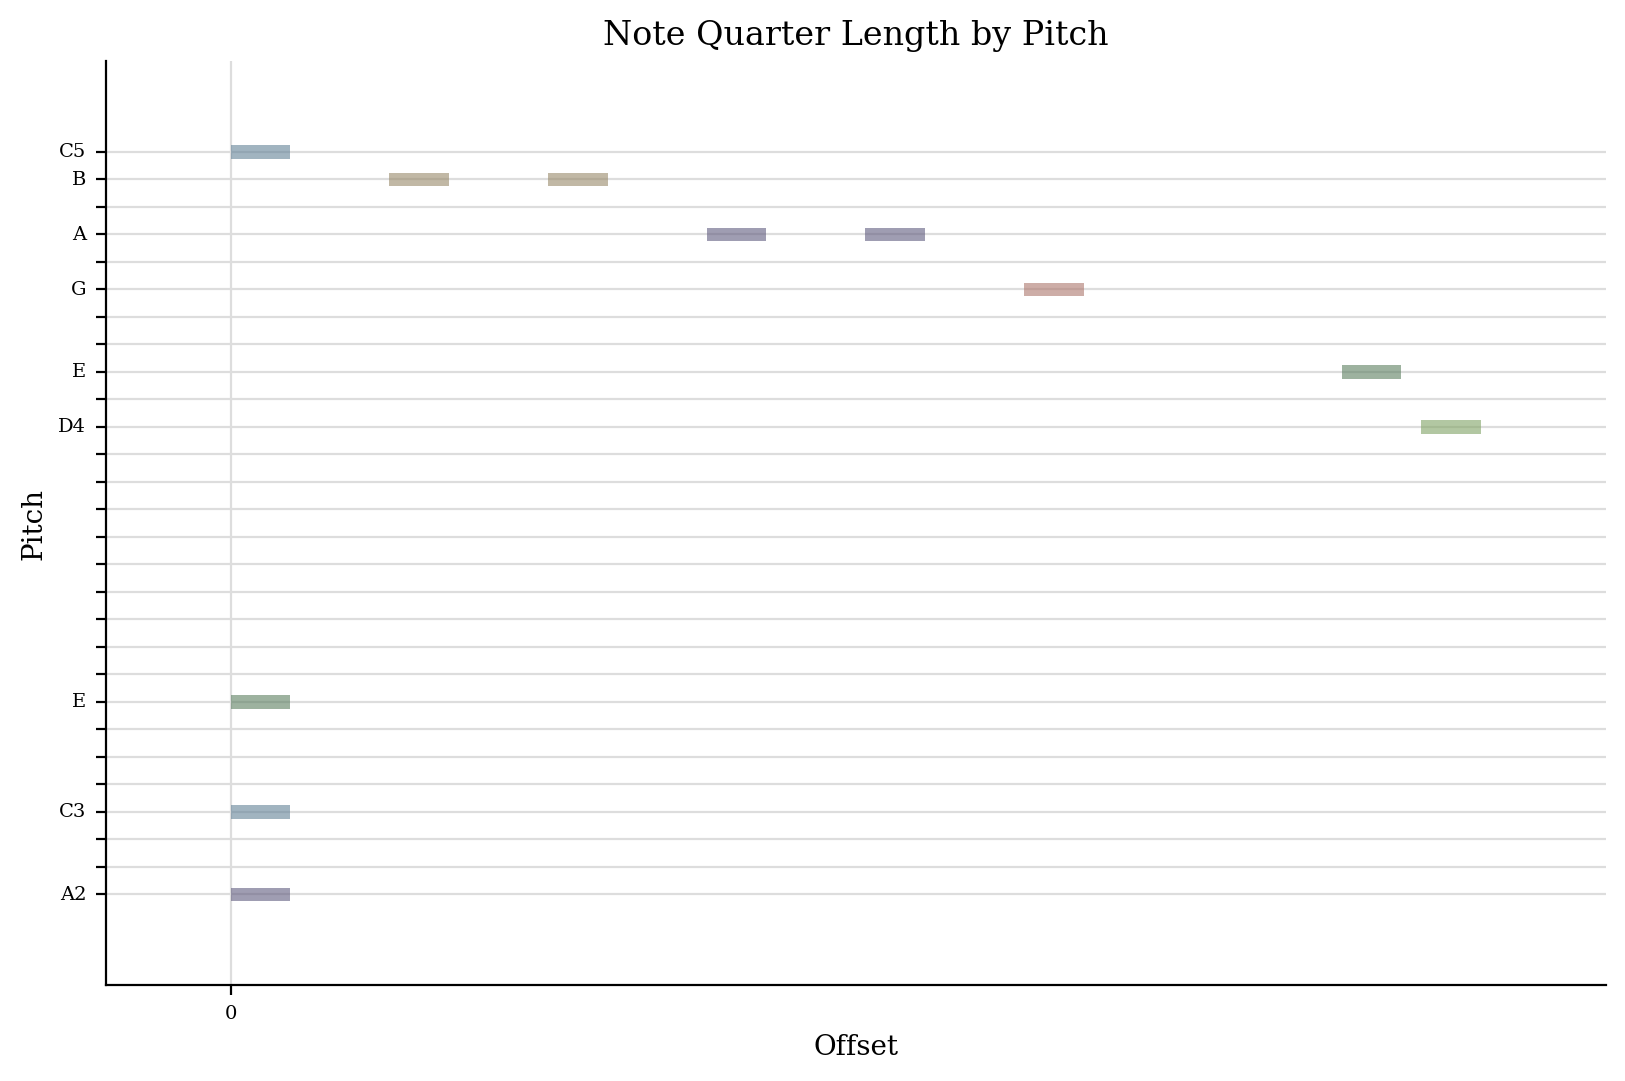

In [83]:
reconstructed_stream = idx_to_stream_enc(idx_score, vocab)
reconstructed_stream.plot()

As it stands this is essentially character-level encoding.

We haven't chunked tokens by training on example data. We simply have a single dedicated token for each note, duration and delimiter.

Perhaps we would have commonly lots of spaces, so separators would have chunked versions (e.g. '`<sep><sep>`', '`<sep><sep><sep>`' etc). That would save long silences using up all the context width (similar to how GPT grouping spaces to make source code easier to parse).

Also if we trained on enough data we would possibly find common riffs / melodies / progressions / rhythms etc that would form a richer, expressive vocabulary.

I can imagine blues licks chunking as they would show up a lot, and then being embedded in such a way that the model knows there is a blues vibe to the song.

If drum encoding is implemented, perhaps it would chunk a paradiddle?

In order to do that we need to load a lot of data (at least enough to train the tokeniser to find common motifs).

That's going to require parsing large numbers of files, dealing with bad data and odd structures, plus saving and loading the results.

Once we have loaded and processed the data into batches, we can use a BPE (byte pair encoding) algorithm to chunk the tokens.

### Preparing data

First lets factor the MIDI file loading and converting functions out so we can reuse them.

Here is a plot of the final fantasy file we opened at the top of the workbook:

In [84]:
def import_midi_file(file_path):
    midifile = m21.midi.MidiFile()
    if isinstance(file_path, bytes):
        midifile.readstr(file_path)
    else:
        midifile.open(file_path)
        midifile.read()
        midifile.close()
    return midifile

def midifile_to_stream(midifile): 
    return m21.midi.translate.midiFileToStream(midifile)

def midifile_to_idx_score(file_path, vocab):
    midifile = import_midi_file(file_path)
    stream = midifile_to_stream(midifile)
    sparse_score = stream_to_sparse_enc(stream)
    note_pos_score = sparse_to_note_position_enc(sparse_score)
    return note_position_to_idx_enc(note_pos_score, vocab)

Let's see if we can load and encode final fantasy in one step:

In [85]:
final_fantasy_idx_score = midifile_to_idx_score(final_fantasy_midi_path, vocab)
vocab.to_tokens(midifile_to_idx_score(final_fantasy_midi_path, vocab))

'<sos> <pad> n62 d1 <sep> d1 n64 d1 n59 d1 <sep> d2 n61 d1 <sep> d1 n66 d1 <sep> d1 n67 d1 n62 d1 <sep> d2 n64 d1 <sep> d1 n66 d1 <sep> d1 n64 d1 n62 d1 <sep> d2 n61 d1 <sep> d1 n62 d1 <sep> d1 n66 d1 n59 d1 <sep> d1 n71 d1 n64 d1 <sep> d1 n73 d1 <sep> d1 n74 d8 n66 d2 n47 d2 <sep> d2 n67 d2 n59 d2 <sep> d2 n66 d2 n47 d2 <sep> d2 n64 d1 n59 d2 <sep> d1 n66 d3 <sep> d1 n47 d2 <sep> d2 n74 d2 n66 d2 n59 d2 <sep> d2 n76 d2 n67 d2 n47 d2 <sep> d2 n78 d2 n69 d2 n59 d2 <sep> d2 n78 d2 n69 d2 n45 d2 <sep> d2 n57 d2 <sep> d1 n76 d3 n67 d3 <sep> d1 n45 d2 <sep> d2 n74 d2 n66 d2 n57 d2 <sep> d2 n73 d6 n64 d2 n45 d2 <sep> d2 n61 d2 n57 d2 <sep> d2 n64 d2 n45 d2 <sep> d2 n73 d1 n71 d1 n69 d1 n67 d1 n57 d1 <sep> d2 n74 d8 n71 d2 n43 d2 <sep> d2 n69 d2 n55 d2 <sep> d2 n67 d2 n43 d2 <sep> d2 n69 d1 n55 d2 <sep> d1 n71 d5 <sep> d1 n43 d2 <sep> d2 n74 d2 n55 d2 <sep> d2 n76 d2 n73 d2 n43 d2 <sep> d2 n74 d2 n71 d2 n55 d2 <sep> d2 n73 d2 n69 d2 n42 d2 <sep> d2 n54 d2 <sep> d1 n71 d3 n66 d3 <sep> d1 n42 d